In [145]:
import torch
import torch.nn as nn
import torchvision.io
import torch.nn.functional as F
import pandas
import numpy as np
import matplotlib.pyplot as plt
import kornia.color
from matplotlib import colors

blocksize=100
gridsize=10
gridcells=(int)(blocksize/gridsize)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

#Convolution block wrapper, autopadding
class convblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.activate = activation_func(activation)
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        x = self.convolute(x)
        x = self.activate(x)
        x = self.batchnorm(x)
        return x

class deconvblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute = nn.ConvTranspose2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.activate = activation_func(activation)
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        x = self.convolute(x)
        x = self.activate(x)
        x = self.batchnorm(x)
        return x

class resblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.convolute2 = nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, 1, self.kernel_size//2)
        self.activate1 = activation_func(activation)
        self.activate2 = activation_func(activation)
        self.batchnorm1 = nn.BatchNorm2d(self.in_channels)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.propagate = nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.in_channels)
    def forward(self, x):
        res = self.batchnorm3(x)
        res = self.propagate(res)
        x = self.batchnorm1(x)
        x = self.activate1(x)
        x = self.convolute1(x)
        x = self.batchnorm2(x)
        x = self.activate2(x)
        x = self.convolute2(x)
        x += res
        return x


class audioSepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, depth=1, block=resblk, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Sequential(block(in_channels, out_channels, kernel_size, stride, activation),\
            *[block(out_channels, out_channels, kernel_size, 1, activation) for _ in range(depth - 1)])
      
    def forward(self, x):
        x = self.blocks(x)
            
        return x
        
#Sensitive Paramaters
CHANNEL_SCALE = 32
ACTIVATION = 'relu'
#Audio Seperation Network
class audioSep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = audioSepLayer(6, 6, 1, 1, 1, activation=ACTIVATION)
        self.layer2 = audioSepLayer(6, CHANNEL_SCALE, 7, 4, 3, activation=ACTIVATION)
        self.layer3 = audioSepLayer(CHANNEL_SCALE, CHANNEL_SCALE*2, 5, 3, 3, activation=ACTIVATION)
        self.layer4 = audioSepLayer(CHANNEL_SCALE*2, CHANNEL_SCALE*4, 5, 3, 3, activation=ACTIVATION)
        self.pool = nn.AvgPool2d(4,4)
        self.fc1 = nn.Linear(1152, gridsize*gridsize*2)

    def forward(self, x):
        src = x
        #x = x[:,None]
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return(x.view(-1,gridsize*gridsize,2))
    
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



#Loss functions
class loss_wrapper(torch.nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss_func = loss_func
    
    def forward(self, x, y):
        return self.loss_func(x,y)

#Classifier
def hinge_loss(x, y):
    loss = 1 - x * y
    return torch.mean(torch.where(loss < 0, torch.zeros_like(loss), loss))

def mispredict_loss(x,y):
    loss = - x * y
    return torch.mean(torch.where(loss < 0, torch.zeros_like(loss), loss))

def incorrect(x,y):
    return torch.sum(x*y < 0) / len(x)

#Regression
def MSE_loss(x, y):
    loss = torch.pow(y - x, 2)
    return torch.mean(loss)

def MAE_loss(x, y):
    return torch.mean(torch.abs(y - x))


def l2_regularizer(model, loss, strength):
    def reg_loss(x, y):
        return loss(x,y) + strength * torch.sum(torch.pow(torch.cat([param for param in model.parameters()]),2))
    return reg_loss

def l1_regularizer(model, loss, strength):
    def reg_loss(x, y):
        return loss(x,y) + strength * torch.sum(torch.abs(torch.cat([param for param in model.parameters()])))
    return reg_loss

def rbf(x, z, gamma):
    return torch.exp(- gamma * torch.sum(torch.pow(x-z,2), dim=-1))

def kernel_mat(kernel, x, **kwargs):
    return kernel(x[:,None,:] , x[None,:,:], **kwargs)

In [272]:
def vectoimg(vectors, source):
    grid = torch.stack(list(torch.meshgrid(torch.arange(0,gridsize*2./blocksize,2./blocksize),torch.arange(0,gridsize*2./blocksize,2./blocksize))),dim=2)
    grid = torch.flatten(grid,0,1)
    vectors = torch.unsqueeze(vectors, -2)
    blocks = grid + vectors
    blocks = blocks.view(*blocks.shape[:2],10,10,2)
    print(blocks)
    pred = torch.empty(len(vectors), 3, blocksize, blocksize)
    for i in range(gridcells):
        for j in range(gridcells):
            pred[:,:,i*gridsize:(i+1)*gridsize,j*gridsize:(j+1)*gridsize] = F.grid_sample(source, blocks[:,i*gridcells+j])
    return pred

In [266]:
def learn(net, optimizer, loss_func, X, y, batch_size=50, device='cpu'):

    torch.backends.cudnn.fastest = True
    calc = loss_func
    net.train()
    totalloss=0
    indicies = torch.randperm(len(X))
    batches = int(np.floor(len(X)/batch_size))
    for batch in range(batches):
        optimizer.zero_grad()
        tx = X[indicies[batch*batch_size:(batch+1)*batch_size]].to(device)
        ty = y[indicies[batch*batch_size:(batch+1)*batch_size]].to(device)
        vectors = net(tx)
        print(vectors)
        pred = vectoimg(vectors, tx[:,:3])
        loss = calc(pred, ty)
        totalloss += loss.detach()
        loss.backward()
        optimizer.step()
    loss = totalloss/batches
    return loss.item()

def test(net, loss_func, X, y, batch_size=50, device='cpu'):

    calc = loss_func
    net.eval()
    totalloss=0
    batches = int(np.floor(len(X)/batch_size))
    for batch in range(batches):
        tx = X[batch*batch_size:(batch+1)*batch_size].to(device)
        ty = y[batch*batch_size:(batch+1)*batch_size].to(device)
        vectors = net(tx).detach()
        pred = vectoimg(vectors,tx[:,:3])
        totalloss += calc(pred, ty)
    loss = totalloss/batches
    return loss.item()

from IPython import display
def plot_train(trainloss, testloss):
    plt.clf()
    plt.plot(np.linspace(2,len(trainloss),len(trainloss)-1), trainloss[1:], label="train")
    plt.plot(np.linspace(2,len(testloss),len(testloss)-1), testloss[1:], label="test")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss') 
    display.display(plt.gcf())
    plt.show()
    display.clear_output(wait=True)


def train(model, optimizer, loss, X, y, validation_size, batch_size=100, epochs=1, plot=False, verbose=False, metric=mispredict_loss):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ind = np.random.permutation(len(y))
    validationX = X[ind[:validation_size]]
    validationy = y[ind[:validation_size]]
    trainX = X[ind[validation_size:]]
    trainy = y[ind[validation_size:]]
    trainloss = []
    validation_loss = []
    plt.ion()
    epoch = 0
    for i in range(epochs):
        trainloss.append(learn(model, optimizer, loss, trainX, trainy, batch_size=batch_size, device=device))
        validation_loss.append(test(model, loss, validationX, validationy, batch_size=batch_size, device=device))
        if(verbose):
            print("Epoch:", i+1)
            print("Train loss:", trainloss[i])
            print("validation loss:", validation_loss[i])
        epoch += 1
    if(plot):
        plot_train(trainloss,validation_loss)
    Err = test(model, loss_wrapper(metric), validationX, validationy, batch_size=batch_size, device=device)
    print("Average Error (MAE): " + str(Err))
    

In [237]:
vid = torch.swapaxes(torch.swapaxes(torchvision.io.read_video("mov_bbb.mp4",0,10,pts_unit='sec')[0],2,3),1,2)/256
mapped = kornia.color.rgb_to_yuv(vid)

In [267]:
randlocx = torch.randint(0,mapped.shape[3]-blocksize, (mapped.shape[0],))
randlocy = torch.randint(0,mapped.shape[2]-blocksize, (mapped.shape[0],))
features = torch.empty((mapped.shape[0],2*mapped.shape[1],blocksize,blocksize))
targets = torch.empty((mapped.shape[0],mapped.shape[1],blocksize,blocksize))
for i in range(mapped.shape[0]-2):
    features[i,:mapped.shape[1]] = mapped[i,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]
    features[i,mapped.shape[1]:] = mapped[i+2,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]
    targets[i] = mapped[i+1,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]

In [268]:
net = audioSep()
optim = torch.optim.Adam(net.parameters(), 0.001)
train(net, optim, MSE_loss, features, targets, 50, 2, epochs=10, plot=True)

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Average Error (MAE): 7.784662557241973e-06


tensor([[[[[ 0.0222, -0.2731],
           [ 0.0222, -0.2531],
           [ 0.0222, -0.2331],
           ...,
           [ 0.0222, -0.1331],
           [ 0.0222, -0.1131],
           [ 0.0222, -0.0931]],

          [[ 0.0422, -0.2731],
           [ 0.0422, -0.2531],
           [ 0.0422, -0.2331],
           ...,
           [ 0.0422, -0.1331],
           [ 0.0422, -0.1131],
           [ 0.0422, -0.0931]],

          [[ 0.0622, -0.2731],
           [ 0.0622, -0.2531],
           [ 0.0622, -0.2331],
           ...,
           [ 0.0622, -0.1331],
           [ 0.0622, -0.1131],
           [ 0.0622, -0.0931]],

          ...,

          [[ 0.1622, -0.2731],
           [ 0.1622, -0.2531],
           [ 0.1622, -0.2331],
           ...,
           [ 0.1622, -0.1331],
           [ 0.1622, -0.1131],
           [ 0.1622, -0.0931]],

          [[ 0.1822, -0.2731],
           [ 0.1822, -0.2531],
           [ 0.1822, -0.2331],
           ...,
           [ 0.1822, -0.1331],
           [ 0.1822, -0.1131

<Figure size 432x288 with 0 Axes>

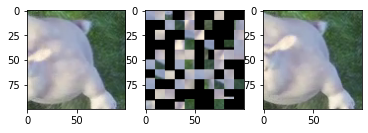

In [274]:
frame = 20
vectors = net(features[frame:frame+1]).detach()
img = vectoimg(vectors, features[frame:frame+1,:3])[0]

# grid = torch.stack(list(torch.meshgrid(torch.arange(0,gridsize*2./blocksize,2./blocksize),torch.arange(0,gridsize*2./blocksize,2./blocksize))),dim=2)
# grid = torch.flatten(grid,0,1)
# blocks = grid - 0.99
# print(blocks.shape)
# blocks = blocks.view(1,10,10,2)
# img = F.grid_sample(features[frame:frame+1,:3], blocks)[0]

plt.figure()
fig, subplot = plt.subplots(1,3) 
subplot[0].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(features[frame,:3]),0,2),0,1))
subplot[1].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(img),0,2),0,1))
subplot[2].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(features[frame,3:]),0,2),0,1))

In [271]:
print(vectors)

tensor([[[ 0.0222, -0.2731],
         [ 0.1497,  0.3345],
         [ 0.7254,  0.8554],
         [-1.2441, -0.5839],
         [-0.7319, -0.3623],
         [ 1.5877, -1.8838],
         [ 1.0538, -0.1550],
         [-0.3462,  0.3191],
         [-2.0275, -0.7088],
         [-2.0445, -0.4724],
         [-2.4286, -0.3607],
         [ 0.0073, -2.1932],
         [-0.5137, -0.6743],
         [ 0.4788,  0.1963],
         [-0.6879, -0.0573],
         [-2.2693, -0.7684],
         [ 0.0253,  0.8473],
         [-2.4122,  1.0107],
         [-1.8648,  0.2190],
         [-0.6177, -0.8701],
         [-3.3325, -2.4399],
         [-0.8847, -0.6396],
         [ 1.4352, -2.7575],
         [-1.3172, -0.8040],
         [ 0.1840, -0.1278],
         [-0.9028, -0.2286],
         [-0.7497, -2.6027],
         [ 1.6272,  1.4247],
         [-1.1893, -1.8260],
         [-0.6335, -0.4494],
         [-1.7598, -2.6251],
         [-1.4217,  0.5312],
         [-3.7045, -1.0743],
         [-0.9058, -0.1210],
         [ 0.3